In [2]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [15]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
γ3_list = np.array([0, 0.0197*2, 0.3853*2])
# y_jump=2
# y = 2.5
# damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
# damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
# damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 40)
# γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
# γ3_list = np.flip(γ3_list)
# γ3_list[0] = 0

# γ3_list = γ3_list[:20]
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [16]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [17]:
def solve_baseline(y_grid, numy_bar, ems_star, ϕ_list, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy = args
#     args_list = []
#     for γ3_i in γ3_list:
#         args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, ξa, ξw)
#         args_iter = (y_grid, args_func, 2000, 1e-7, 3)
#         args_list.append(args_iter)
  
#   res_list = ode_y_parallel(args_list)
    
#     ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
#     for j in range(len(γ3_list)):
#         ϕ_list[j] = res_list[j]['φ']

#     ems_star = solu['ems']
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dy = y_grid_cap[1] - y_grid_cap[0]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    θ = θ_list@πᶜo 
    g_list = np.ones((len(γ3_list), len(y_grid_cap)))
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity*((dmg_weight*ϕ_list[:, numy_bar])@g_list)
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [18]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [19]:
from multiprocessing import Pool

# test for ξ_p = 2
# baseline
ξa = 0.01
ξw = 100_000
# ξp = 5
hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [291]:
# args_list = []
# for y_tilde in jump_interval[-1:]:
#     for γ3_i in γ3_list[1:]:
#         args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw)
#         args_iter = (y_grid, args_func, 2000, 1e-7, 3)
#         args_list.append(args_iter)

args_list = []
for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 1.5, ξa, ξw)
    args_iter = (y_grid, args_func, 2000, 1e-7, 0.5)
    args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        

In [292]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

episode: 2000,	 ode error: 0.0012666035604290806,	 ft error: 4.956871396899487e-06
episode: 2000,	 ode error: 0.00014023575086150042,	 ft error: 3.7220683431371526e-05
episode: 2000,	 ode error: 0.0003040375619679514,	 ft error: 1.521969058337902e-06


'00h00m14s'

In [565]:
# pickle.dump(res_list, open("../data/damage_prep_40_0.01.p", "wb"))

In [566]:
# res_dict = pickle.load(open('../../damage_prep_40_tight.p', 'rb'))

# ϕ_ref = res_dict['φ_ref']
# ems_ref = res_dict['ems_ref']
# res_list = res_dict['res_list']
# ems_list = res_dict['ems_list']
# ϕ_list = res_dict['φ_list']

In [22]:
# construct ϕ_m
pre_jump = np.arange(y_min, 2 + hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [568]:
# res_test = res_list # + res_list_ex

# ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
# ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

# count = 0
# for i, y_tilde in enumerate(jump_interval):
#     ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
#     ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
#     for j in range(len(γ3_list[1:])):
#         ϕ_ref[j+1, i + len(prepre_jump)] = res_test[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
#         ems_ref[j+1, i + len(prepre_jump)] = res_test[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [569]:
# ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
# ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
# for i, y_tilde in enumerate(jump_interval):
#     ϕ_list[i, 0] = solution_low['φ']
#     ems_list[i, 0] = solution_low['ems']
#     for j in range(len(γ3_list[1:])):
#         ϕ_list[i, j + 1] = res_test[i*len(γ3_list[1:]) + j]['φ']
#         ems_list[i, j + 1] = res_test[i*len(γ3_list[1:]) + j]['ems']

In [219]:
ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(γ3_list), len(y_grid)))

for j in range(len(γ3_list)):
    ϕ_list[j ] = res_list[ j]['φ']
    ems_list[ j ] = res_list[ j]['ems']

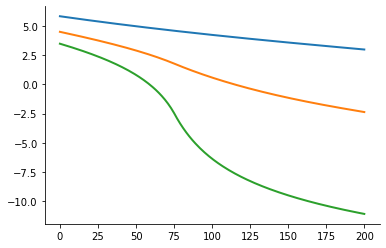

In [220]:
plt.plot(ϕ_list.T)
plt.show()

In [572]:
# res_dict = dict(res_list=res_test, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
# res_dict = dict(res_list=res_list, ϕ_list=ϕ_list, ems_list=ems_list)
# pickle.dump(res_dict, open("../data/damage_prep_40_5.p", "wb"))

In [573]:
# res_dict_long = pickle.load(open('../data/damage_prep_40.p', 'rb'))

# ϕ_ref = res_dict_long['φ_ref']
# ems_ref = res_dict_long['ems_ref']
# res_list = res_dict_long['res_list']
# ems_list = res_dict_long['ems_list']
# ϕ_list = res_dict_long['φ_list']

In [27]:
def solve_baseline_prep(y_grid, ems_star, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3, ȳ, dmg_weight, ξp, ξa, ξw, σy = args
#     ems_star = solu['ems']
    # solve for HJB with jump function
#     y_grid_cap = y_grid[:numy_bar+1]
    numy_bar = len(pre_jump)
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid>ȳ)
    πᶜo = np.ones((len(θ_list), len(y_grid)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = -δ*np.ones(y_grid.shape)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [221]:
ϕ_list.shape

(3, 201)

In [222]:
ems_list.shape

(3, 201)

In [223]:
me_list = np.zeros((len(γ3_list), len(y_grid)))
ratio_list = np.zeros((len(γ3_list), len(y_grid)))

for i in range(len(γ3_list)):
    args_baseline = (δ, η, θ_list, γ1, γ2, γ3_list[i], 2, dmg_weight, 100_000, 100_000, 100_000, σy )
    ems_star = ems_list[i]
    me_baseline = solve_baseline_prep(y_grid, ems_star, args_baseline, ϵ=1)
    me_list[i] = me_baseline[0]
    ratio_list[i] = me_baseline[1]

episode: 3000,	 ode error: 0.0001056850728361064,	 ft error: 6.1168965386215746e-06
episode: 1362,	 ode error: 0.00030622117365066565,	 ft error: 9.954057134109462e-09
episode: 1584,	 ode error: 0.0007198861293860417,	 ft error: 9.974346681929092e-09


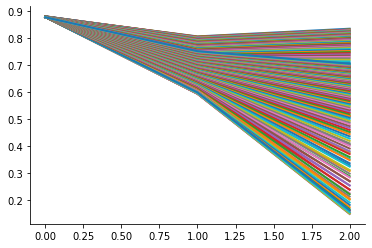

In [224]:
plt.plot(ratio_list)
plt.show()

In [243]:
1- ratio_list.max(), 1- ratio_list.min(), ratio_list.shape

(0.11778673177830401, 0.8512233099567535, (3, 201))

# Step 2: HJB

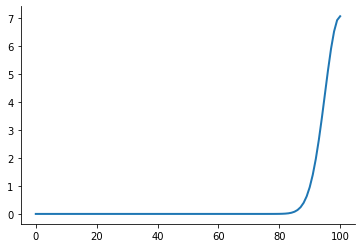

In [244]:
plt.plot(intensity)

In [227]:
test = (δ, η, θ_list, γ1, γ2, γ3_list, 2, dmg_weight, ς, ξp, ξa, ξw, σy) 
test_solu = solve_jump_100(y_grid, numy_bar, ϕ_list, test, 2, 1e-7, 2000)

episode: 229,	 ode error: 0.0021698642503988064,	 ft error: 9.904866815624302e-08


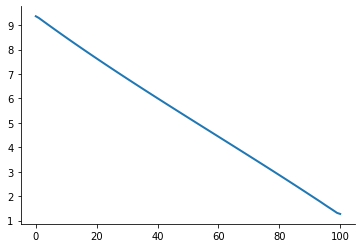

In [228]:
plt.plot(test_solu['ems'])

In [289]:
ξa = 0.01
ξp = 5
ξw = 100_000
σy=1.2*np.mean(θ_list)

numy_bar = len(pre_jump) -1
y_grid_cap = y_grid[:numy_bar+1]


r1=1.5
r2=2.5

y_lower = 1.5
# intensity = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
ς = 0.01

intensity = 1/(np.sqrt(2)*ς)*np.exp(-(y_grid_cap - 2)**2/(2*ς**2))
# intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)
dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2

ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]


dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)

ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(ϕ_average2)

# ϕ = ϕ_bound[:numy_bar+1]

# bound_neumann1 = (cert_equiv[numy_bar] - cert_equiv[numy_bar-1])/dy
# bound_neumann2 = (cert_equiv[numy_bar] -2*cert_equiv[numy_bar-1] + cert_equiv[numy_bar-2])/(dy**2)
# ϕ_bound = np.average(ϕ_list2, weights=dmg_weight, axis=0)

# bound_set=(bound_neumann1, bound_neumann2)

tol= 1e-8
ϵ = 0.5
max_iter = 2000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, (0,0),  False, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    
    if σy == 0:
        ems_new = - η/(temp*(θ_list@πᶜ))
    else:
        a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
        b = (θ_list@πᶜ)*temp
        c = η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
    
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    ϕ_ref = np.zeros((len(γ3_list), len(y_grid_cap)))
    for i in range(len(γ3_list)):
        ϕ_ref[i] = ϕ_list[i, :numy_bar+1]
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)  - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity*(dmg_weight@(g_list*(ϕ_ref)))
    # solver
    
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ,(False, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution_no = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 220.27114092974693,	 ft error: 3.1464352041455075
episode: 2,	 ode error: 184.93672221915043,	 ft error: 0.8234794306217701
episode: 3,	 ode error: 173.7246584195545,	 ft error: 0.22647265093405378
episode: 4,	 ode error: 173.00637184349938,	 ft error: 0.16977367745492855
episode: 5,	 ode error: 172.98808596225555,	 ft error: 0.13985756624869428
episode: 6,	 ode error: 172.98933047223537,	 ft error: 0.12298868674087204
episode: 7,	 ode error: 172.98980870614585,	 ft error: 0.11220612345236036
episode: 8,	 ode error: 172.9895200835912,	 ft error: 0.10438751280621172
episode: 9,	 ode error: 172.98892064819677,	 ft error: 0.09814280989472968
episode: 10,	 ode error: 172.98823081709529,	 ft error: 0.09283169180029738
episode: 11,	 ode error: 172.98752720260796,	 ft error: 0.08814082135028123
episode: 12,	 ode error: 172.98682744108112,	 ft error: 0.08390346020333483
episode: 13,	 ode error: 172.9861337848805,	 ft error: 0.08002152192522916
episode: 14,	 ode error: 1

episode: 143,	 ode error: 172.9630789037424,	 ft error: 0.014916660178649455
episode: 144,	 ode error: 172.96307834454896,	 ft error: 0.014826466845555664
episode: 145,	 ode error: 172.96307917146567,	 ft error: 0.014732222819959895
episode: 146,	 ode error: 172.96307942769323,	 ft error: 0.01463392426112764
episode: 147,	 ode error: 172.9630793318861,	 ft error: 0.01453157000979921
episode: 148,	 ode error: 172.96307917101015,	 ft error: 0.01442516189662213
episode: 149,	 ode error: 172.96307944953168,	 ft error: 0.014314705070770817
episode: 150,	 ode error: 172.96307958152502,	 ft error: 0.014200208327945218
episode: 151,	 ode error: 172.96307958887274,	 ft error: 0.014081684448395082
episode: 152,	 ode error: 172.9630800853698,	 ft error: 0.013959150533889741
episode: 153,	 ode error: 172.96307983014037,	 ft error: 0.013872047111310792
episode: 154,	 ode error: 172.9630799880863,	 ft error: 0.013790239757905776
episode: 155,	 ode error: 172.96308074365564,	 ft error: 0.013704804087

episode: 298,	 ode error: 172.96308474478062,	 ft error: 0.005533405827808924
episode: 299,	 ode error: 172.96308413700862,	 ft error: 0.005499083482735312
episode: 300,	 ode error: 172.96308519241754,	 ft error: 0.005469320283344015
episode: 301,	 ode error: 172.96308452233592,	 ft error: 0.005438568818671108
episode: 302,	 ode error: 172.96308459439763,	 ft error: 0.005406829777993671
episode: 303,	 ode error: 172.96308411783667,	 ft error: 0.005374104578812489
episode: 304,	 ode error: 172.9630839743351,	 ft error: 0.005340637365584211
episode: 305,	 ode error: 172.96308394515404,	 ft error: 0.005311819640866577
episode: 306,	 ode error: 172.96308429406855,	 ft error: 0.005282051496727558
episode: 307,	 ode error: 172.96308431842684,	 ft error: 0.005251333702813721
episode: 308,	 ode error: 172.96308374960068,	 ft error: 0.00521966772382898
episode: 309,	 ode error: 172.96308357118303,	 ft error: 0.005187522238694342
episode: 310,	 ode error: 172.96308351372195,	 ft error: 0.0051594

episode: 442,	 ode error: 172.96308432844907,	 ft error: 0.0024535196377879487
episode: 443,	 ode error: 172.96308429232505,	 ft error: 0.0024397838844691933
episode: 444,	 ode error: 172.96308518852078,	 ft error: 0.002426763432393564
episode: 445,	 ode error: 172.96308472625046,	 ft error: 0.0024133927579752523
episode: 446,	 ode error: 172.9630848380536,	 ft error: 0.0024000954004739228
episode: 447,	 ode error: 172.96308446784238,	 ft error: 0.002387177377383587
episode: 448,	 ode error: 172.96308531533776,	 ft error: 0.0023739158865163645
episode: 449,	 ode error: 172.96308526911224,	 ft error: 0.0023610609775479574
episode: 450,	 ode error: 172.96308447836827,	 ft error: 0.002348232349310919
episode: 451,	 ode error: 172.96308516165732,	 ft error: 0.002335076218953347
episode: 452,	 ode error: 172.9630842274518,	 ft error: 0.0023226566568093077
episode: 453,	 ode error: 172.96308551419835,	 ft error: 0.002309905303194526
episode: 454,	 ode error: 172.96308506154915,	 ft error: 0.

episode: 578,	 ode error: 172.9630857002268,	 ft error: 0.0007410462410106788
episode: 579,	 ode error: 172.9630859471518,	 ft error: 0.0007265647738741166
episode: 580,	 ode error: 172.9630863288323,	 ft error: 0.0007122086216124757
episode: 581,	 ode error: 172.96308610857767,	 ft error: 0.0006979821748078763
episode: 582,	 ode error: 172.96308612327496,	 ft error: 0.0006838896461562882
episode: 583,	 ode error: 172.96308609395953,	 ft error: 0.0006699350668295523
episode: 584,	 ode error: 172.9630859940528,	 ft error: 0.0006561222849850168
episode: 585,	 ode error: 172.9630856452285,	 ft error: 0.0006424549637458199
episode: 586,	 ode error: 172.96308593974572,	 ft error: 0.0006289365794600599
episode: 587,	 ode error: 172.96308615506945,	 ft error: 0.0006155704208747892
episode: 588,	 ode error: 172.96308563645013,	 ft error: 0.0006023595889512734
episode: 589,	 ode error: 172.96308540009278,	 ft error: 0.0005893069951827812
episode: 590,	 ode error: 172.96308642220723,	 ft error: 

episode: 712,	 ode error: 172.96308512674386,	 ft error: 1.1612021955542673e-05
episode: 713,	 ode error: 172.96308465079574,	 ft error: 1.1152660432500738e-05
episode: 714,	 ode error: 172.96308425570075,	 ft error: 1.070968476213352e-05
episode: 715,	 ode error: 172.96308500818824,	 ft error: 1.0282554343987726e-05
episode: 716,	 ode error: 172.96308521415202,	 ft error: 9.870746321638535e-06
episode: 717,	 ode error: 172.9630854453476,	 ft error: 9.473753323163692e-06
episode: 718,	 ode error: 172.9630847172175,	 ft error: 9.091082336709633e-06
episode: 719,	 ode error: 172.9630857335653,	 ft error: 8.722258696636231e-06
episode: 720,	 ode error: 172.96308528842897,	 ft error: 8.366816821592238e-06
episode: 721,	 ode error: 172.96308579227394,	 ft error: 8.024311792809158e-06
episode: 722,	 ode error: 172.96308521589123,	 ft error: 7.694306489725022e-06
episode: 723,	 ode error: 172.96308497430337,	 ft error: 7.376381010004707e-06
episode: 724,	 ode error: 172.96308534081896,	 ft er

episode: 848,	 ode error: 172.9630848945766,	 ft error: 4.462772649205249e-07
episode: 849,	 ode error: 172.96308421022354,	 ft error: 4.437141303270664e-07
episode: 850,	 ode error: 172.96308494974556,	 ft error: 4.411001741644327e-07
episode: 851,	 ode error: 172.96308541399938,	 ft error: 4.386954524093767e-07
episode: 852,	 ode error: 172.9630841480245,	 ft error: 4.362087082654398e-07
episode: 853,	 ode error: 172.96308502277435,	 ft error: 4.336417820383076e-07
episode: 854,	 ode error: 172.9630842865288,	 ft error: 4.3124465065602635e-07
episode: 855,	 ode error: 172.96308450889313,	 ft error: 4.2882805484367736e-07
episode: 856,	 ode error: 172.96308487014284,	 ft error: 4.2633238273026564e-07
episode: 857,	 ode error: 172.96308553967208,	 ft error: 4.239257895832793e-07
episode: 858,	 ode error: 172.96308471080798,	 ft error: 4.2157344459781143e-07
episode: 859,	 ode error: 172.96308498709828,	 ft error: 4.191433085054541e-07
episode: 860,	 ode error: 172.96308543438892,	 ft e

episode: 986,	 ode error: 172.9630847800958,	 ft error: 1.9647791305033024e-07
episode: 987,	 ode error: 172.96308550822005,	 ft error: 1.9449647226110756e-07
episode: 988,	 ode error: 172.96308459385907,	 ft error: 1.9249405802668207e-07
episode: 989,	 ode error: 172.96308574383198,	 ft error: 1.9047184096621095e-07
episode: 990,	 ode error: 172.96308560092712,	 ft error: 1.8843040017202384e-07
episode: 991,	 ode error: 172.9630854087127,	 ft error: 1.8637057053183526e-07
episode: 992,	 ode error: 172.96308494923625,	 ft error: 1.8429343207060356e-07
episode: 993,	 ode error: 172.96308526067617,	 ft error: 1.821997361872718e-07
episode: 994,	 ode error: 172.96308474781043,	 ft error: 1.8009054691958681e-07
episode: 995,	 ode error: 172.96308491645766,	 ft error: 1.779666813916947e-07
episode: 996,	 ode error: 172.96308506304078,	 ft error: 1.758290935072182e-07
episode: 997,	 ode error: 172.96308501475121,	 ft error: 1.7367819360458725e-07
episode: 998,	 ode error: 172.963084331856,	 

episode: 1117,	 ode error: 172.96308535734627,	 ft error: 3.777945511984626e-08
episode: 1118,	 ode error: 172.9630847136242,	 ft error: 4.645787043955352e-08
episode: 1119,	 ode error: 172.96308550493703,	 ft error: 4.698267197511541e-08
episode: 1120,	 ode error: 172.96308470456978,	 ft error: 3.0946022633315806e-08
episode: 1121,	 ode error: 172.96308523129022,	 ft error: 5.846037698375994e-08
episode: 1122,	 ode error: 172.96308423491544,	 ft error: 5.188337581785163e-08
episode: 1123,	 ode error: 172.9630851184882,	 ft error: 1.4452852248325598e-08
episode: 1124,	 ode error: 172.96308509337115,	 ft error: 2.3400947846141662e-08
episode: 1125,	 ode error: 172.9630846946571,	 ft error: 1.541621585943176e-08
episode: 1126,	 ode error: 172.9630849573608,	 ft error: 4.119707774918879e-08
episode: 1127,	 ode error: 172.9630856600293,	 ft error: 1.4109916790516763e-08
episode: 1128,	 ode error: 172.96308556899595,	 ft error: 4.7007417514066674e-08
episode: 1129,	 ode error: 172.963084767

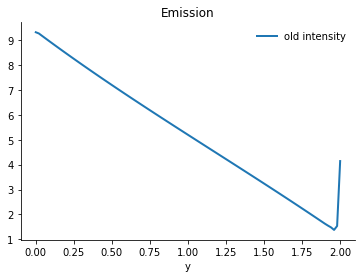

In [290]:
plt.plot(y_grid_cap,solution_no['ems'], label="old intensity")
# plt.plot(y_grid_cap,solution_yes['ems'], label="old intensity")
# plt.plot(y_grid_cap, ems_ref.T)
plt.title("Emission", fontsize=12)
# plt.ylim(0)
plt.xlabel('y')
plt.legend()
# plt.savefig("ems_y_compare.png", dpi=500, bbox_inches='tight')
plt.show()

Text(0.5, 0, 'y')

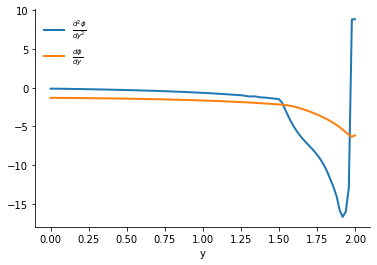

In [201]:
plt.plot(y_grid_cap,dϕdyy, label=r"$\frac{d^2\phi}{dy^2}$")
plt.plot(y_grid_cap,dϕdy, label=r"$\frac{d \phi}{dy}$")
plt.legend()
plt.xlabel('y')
# plt.savefig('derivatives_test.png', facecolor="w", edgecolor='w', dpi=400, bbox_inches='tight')

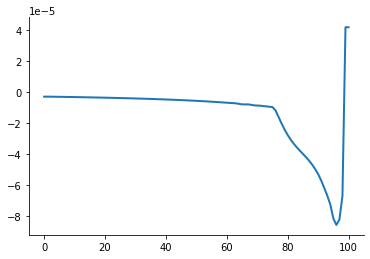

In [202]:
plt.plot(a)

([<matplotlib.lines.Line2D at 0x7ff80c8ac0d0>],
 array([8.83218933, 8.83218933]))

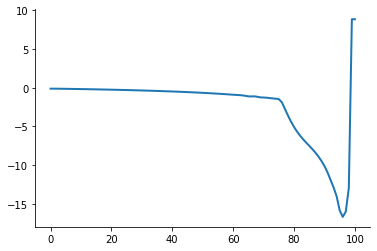

In [203]:
test = derivative_1d(ϕ, 2, dy, (0,0), False, "center")
plt.plot(test), test[-2:]

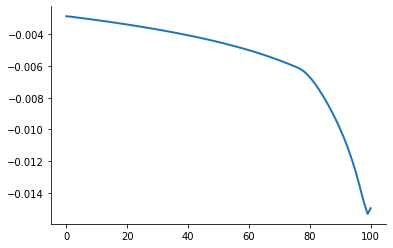

In [204]:
plt.plot(b)

In [205]:
ϕ_list.shape, solution_no['φ'][-1], solution_yes['φ'][-1], ϕ_bound[numy_bar]

((3, 201), 0.3377986080428978, 0.36093231769690465, 0.3609323177024878)

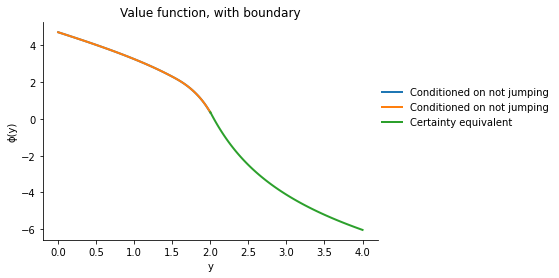

In [206]:
# plt.plot(y_grid_cap[len(prepre_jump):], ϕ_ref[0,len(prepre_jump):], label="Lowest damage specification value function")
plt.plot(y_grid_cap, solution_no['φ'], label="Conditioned on not jumping")
plt.plot(y_grid_cap, solution_yes['φ'], label="Conditioned on not jumping")
# plt.plot(y_grid_cap, solution['φ'])
# plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
average_desination = np.average(ϕ_ref, axis=0)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:],label="Certainty equivalent")
# plt.plot(y_grid_cap[len(prepre_jump):], average_desination[len(prepre_jump):], label="Average value function at each potential jump point")
# plt.plot(y_grid_cap[len(prepre_jump):], ϕ_ref[-1, len(prepre_jump):], label="Highest damage specification value function")
plt.title('Value function, with boundary')
plt.legend(loc=(1,0.5))
plt.xlabel("y")
plt.ylabel("ϕ(y)")
# plt.ylim(0)
# plt.savefig("value_functions_yes.png", facecolor="w", edgecolor="w", dpi=500,  bbox_inches = "tight" )
plt.show()

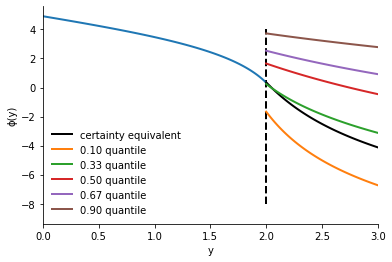

In [207]:
plt.plot(y_grid_cap,solution['φ'])
# plt.plot(y_grid[numy_bar: len(pre_jump)], cert_equiv[numy_bar:])
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="certainty equivalent", color="black")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.1, axis=0), label="0.10 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.33, axis=0), label="0.33 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.5, axis=0), label="0.50 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.67, axis=0), label="0.67 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.9, axis=0), label="0.90 quantile")
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
# plt.title("Value function", fontsize=12)
plt.xlabel('y')
plt.vlines(2, -8, 4, color="black", linestyle="dashed")
plt.legend()

plt.ylabel('ϕ(y)')
plt.xlim(0,3)
# plt.savefig('../figures/20_damages_large/value_match_{}.pdf'.format(ξp))
plt.show()

Text(0.5, 0, '$\\phi_m(2)$')

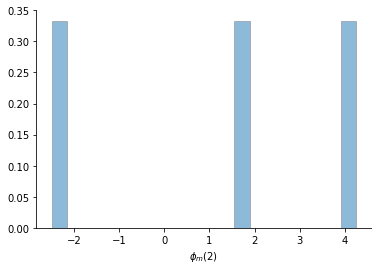

In [191]:
plt.hist(ϕ_list[  :, numy_bar], weights=np.ones_like(ϕ_list[ :, numy_bar])/len(ϕ_list), bins=20, alpha=0.5, ec="gray")
plt.xlabel("$\phi_m(2)$")
# plt.savefig('../figures/20_damages_large/histogram_valuefunc.pdf')

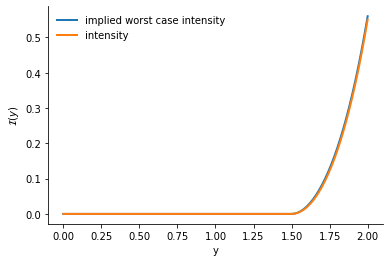

In [893]:
intensity1 = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
worst_case_intensity = dmg_weight@g_list*intensity1
plt.plot(y_grid_cap, worst_case_intensity, label="implied worst case intensity")
plt.plot(y_grid_cap, intensity1, label="intensity")
plt.xlabel('y')
plt.ylabel('$\mathcal{I}(y)$')
plt.legend()
# plt.savefig('../figures/20_damages_large/intensity_{}.pdf'.format( ξp))

In [894]:
y_grid[numy_bar], ϕ_list.shape, jump_interval[-1]

(2.0, (40, 201), 2.0000000000000004)

In [895]:
args_base = (δ, η, θ_list, γ1, γ2, γ3_list, 2, dmg_weight, ς, 100_000, 100_000, 100_000, σy)
me, ratio = solve_baseline(y_grid, numy_bar, solution['ems'], ϕ_list, args_base, ϵ=2)

episode: 189,	 ode error: 0.13136107230435476,	 ft error: 9.661476063627106e-09


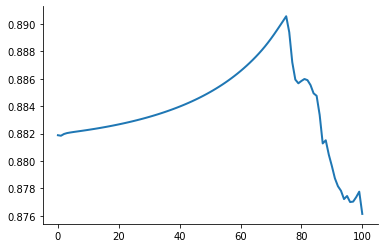

In [896]:
plt.plot(ratio)

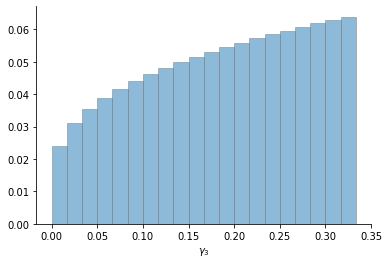

In [897]:
plt.hist(γ3_list, weights=g_list[:,-1]/np.sum(g_list[:,-1]), bins=20, ec="gray", alpha=0.5)
plt.xlabel('$γ_3$')
# plt.savefig("../figures/20_damages/damage_hist.pdf")
plt.show()

In [898]:
dt = 1/4

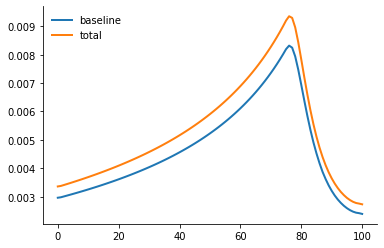

In [899]:
plt.plot(me, label="baseline")
plt.plot(η/solution['ems'], label="total")
plt.legend()

In [900]:
def no_jump_simulation(ems, g_list, me, dt, r1, r2):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    met = np.zeros(T)
    probt = np.zeros(T)
    gt = np.zeros((T, len(g_list)))
    get_g = interpolate.interp1d(y_grid_cap, g_list)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= 2:
            e_i = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            met[t] = me_i
#             met[t] = me_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            g_list = get_g(y)
            gt[t] = g_list 
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    met = met[np.nonzero(met)]
    probt = probt[np.nonzero(probt)]
    gt = gt[:len(yt)]

    return et, yt, probt, gt, met

In [901]:
def no_jump_simulation_long(ems, dt):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]
    
    return et, yt, probt

In [902]:
simul_no1 = no_jump_simulation(ems=solution['ems'],g_list=solution['g_list'], me=me, dt=dt, r1=1.5, r2=2.5)
simul_40 = simul_no1

In [864]:
simul_20 = simul_no1

Text(0.5, 0, '$γ_3$')

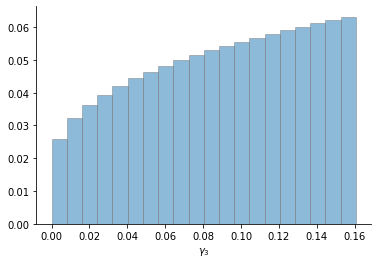

In [865]:
plt.hist(γ3_list, weights=simul_no1[-2][-1]*dmg_weight/np.sum(simul_no1[-2][-1]*dmg_weight), 
         bins=20, ec="gray", alpha=0.5)
plt.xlabel('$γ_3$')
# plt.savefig("../figures/20_damages_large/damage_hist_{}.png".format(ξp), dpi=500)

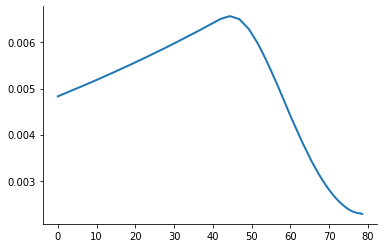

In [866]:
# year = np.arange(0, T-τ, τ)
plt.plot(np.arange(0, len(simul_no1[0])*dt, dt),simul_no1[-1])
# plt.ylim(0)

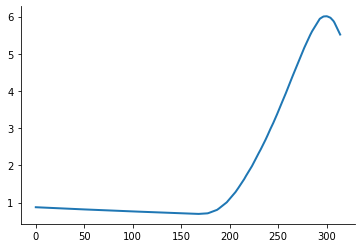

In [911]:
plt.plot(simul_20[0] - simul_40[0][:315])

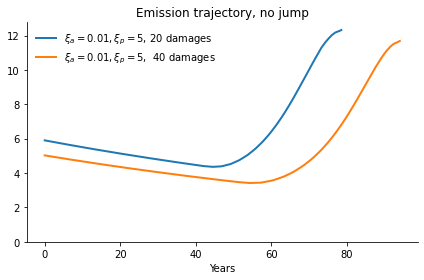

In [930]:
# et_tests = []
# for i in range(len(dmg_weight)):
#     et_test, _, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
#     plt.plot(et_test)
#     et_tests.append(et_test)
plt.plot(np.arange(0, len(simul_20[0])*dt, dt), simul_20[0], linewidth=2, 
         label=r"$\xi_a = {}, \xi_p={}$, 20 damages".format(ξa, ξp)
        )      
plt.plot(np.arange(0, len(simul_no1[0])*dt, dt), simul_no1[0], linewidth=2, 
         label=r"$\xi_a = {}, \xi_p={}$,  40 damages".format(ξa, ξp)
        )    
 
# plt.plot(np.arange(0, len(simul_no1_base[0])*dt, dt), simul_no1_base[0], linewidth=2, label="baseline")    
plt.xlabel('Years')
plt.title("Emission trajectory, no jump", fontsize=12)
plt.legend()
plt.ylim(0)
plt.tight_layout()
# plt.savefig("ems_traj_compare.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

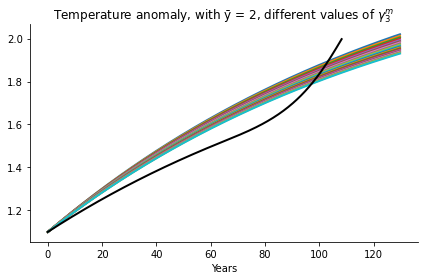

In [802]:
yt_refs = []
for i in range(len(dmg_weight)):
    simul_ref = no_jump_simulation_long(ems_list[ i], dt=dt)
    plt.plot(np.arange(0, len(simul_ref[1])*dt, dt), simul_ref[1], label="$\gamma2$")
    yt_refs.append(simul_ref[1])

# plt.legend()    
plt.plot(np.arange(0, len(simul_no1[1])*dt, dt), simul_no1[1], color="black")
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
plt.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

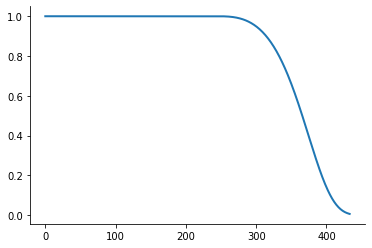

In [803]:
jump_prob = 1 - simul_no1[-3]
integral = np.cumsum(jump_prob)
conti_prob = np.exp(- integral)
plt.plot( conti_prob)

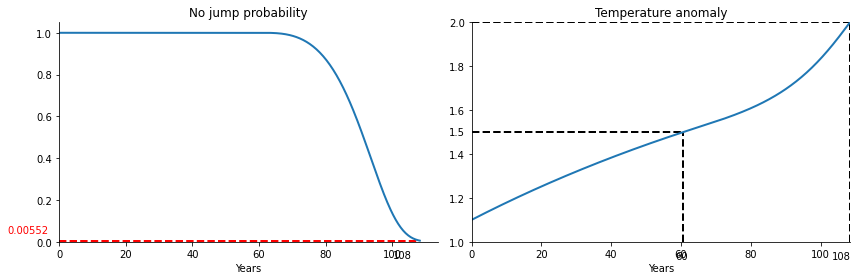

In [804]:
# 1.5, 2.5
import matplotlib.transforms as transforms

yt = simul_no1[1]
T_jump = (np.abs(simul_no1[1]-1.5).argmin())*dt
T_stop = len(simul_no1[0])*dt


Years = np.arange(0, T_stop, dt)
prob_no_jump = np.cumprod(simul_no1[-3])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
# fig.suptitle('{} damage specifications'.format(len(dmg_weight)), y=0.99)


ax1.plot(Years, np.cumprod(simul_no1[-3]))
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")

ax1.text(0.95, -0.066, int(T_stop), transform=trans, ha="right", va="center")

ax2.plot(Years, simul_no1[1])
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop, color="black", linestyle="dashed")
ax2.vlines(T_stop, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, T_stop) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax2.text(0,1.5, 1.5, color="black", transform=trans, ha="right", va="center")

ax2.text(1.02, 0.936, int(T_stop), transform=trans, ha="right", va="center")
ax2.text(0.59, 0.936, int(T_jump), transform=trans, ha="right", va="center")

fig.tight_layout()

# fig.savefig("../figures/prob_anomaly.pdf")
# fig.savefig('prob_anomaly_test.pd',dpi=500, facecolor="w", edgecolor="w")

In [805]:
T_jump, len(simul_no1[0])*dt

(60.5, 108.5)

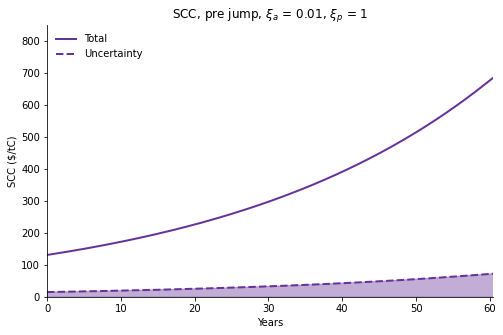

In [806]:
# scc
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, dt=dt, T=120)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))


fig = plt.figure(figsize=(8,5))

et_star = simul_no1[0]
scc = η/et_star/MCt[:len(et_star)]*1000
scc0 = simul_no1[-1]/MCt[:len(et_star)]*1000 
plt.plot(np.arange(0, len(et_star)*dt, dt), scc, color="rebeccapurple", label="Total")

plt.plot(np.arange(0, len(et_star)*dt, dt), scc -scc0, color="rebeccapurple", linestyle="dashed", label="Uncertainty")
plt.fill_between(np.arange(0, len(et_star)*dt, dt), np.zeros_like(scc), 
                 scc-scc0, color='rebeccapurple', alpha=.4)
plt.xlim(0, T_jump)
plt.ylim(0,850)
plt.xlabel("Years")
plt.ylabel("SCC ($/tC)")
plt.legend(loc=2)
plt.title(r'SCC, pre jump, $\xi_a$ = {}, $\xi_p$ = {}'.format(ξa, ξp))
plt.savefig("../figures/20_damages_large/scc_{}.png".format(ξp), dpi=500)

In [807]:
((scc -scc0)/scc)[:int(T_jump/dt)]

array([0.1130082 , 0.11295908, 0.11291626, 0.1128797 , 0.11284937,
       0.11282524, 0.11280726, 0.11279542, 0.11278967, 0.11278998,
       0.11278748, 0.11273808, 0.11269498, 0.11265815, 0.11262755,
       0.11260315, 0.11258492, 0.11257281, 0.11256681, 0.11256686,
       0.11256647, 0.11251558, 0.11247101, 0.11243271, 0.11240066,
       0.11237482, 0.11235515, 0.11234163, 0.11233421, 0.11233287,
       0.11233757, 0.11229213, 0.11224483, 0.11220382, 0.11216908,
       0.11214057, 0.11211825, 0.1121021 , 0.11209207, 0.11208813,
       0.11209025, 0.11206904, 0.1120177 , 0.11197268, 0.11193395,
       0.11190148, 0.11187523, 0.11185517, 0.11184126, 0.11183347,
       0.11183176, 0.11183611, 0.11179177, 0.11174136, 0.11169728,
       0.11165948, 0.11162795, 0.11160264, 0.11158351, 0.11157054,
       0.11156369, 0.11156293, 0.11156822, 0.11151296, 0.11146207,
       0.11141751, 0.11137925, 0.11134727, 0.11132152, 0.11130196,
       0.11128857, 0.11128132, 0.11128016, 0.11128506, 0.11123

In [808]:
def jump_simulation(ems, ems_list, me, ratio, dt, r1, r2):
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
#     ems_list = res_dict['ems_list']
    y0 = 1.1
    y_lower = 1.5
    T_year = 120
    T = int(T_year/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1 - intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1- intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    print(T_final)
    T_extra = T - T_final
    
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    Temp_anol = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    ME = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    RATIO = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        print(t)
        e_i = np.interp(y, y_grid_cap, ems)
        me_i = np.interp(y, y_grid_cap, me)
        ratio_i = np.interp(y, y_grid_cap, ratio)
        intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#         intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        et[t] = e_i
        probt[t] = 1 - intensity*dt
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        Temp_anol[:, t] = y
        PROB[0, t] = prob_no[t]
        EMS[:, t] = et[t]
        ME[:, t] = me_i
        RATIO[:, t] = ratio_i
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        print(t)
        if t == T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            Temp_anol[0, t] = y
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-y_grid).argmin()
                PROB[dmg+1, t] = intensity*dt*dmg_weight[dmg]
                YS[dmg+1, t] =  2
                EMS[dmg+1, t] = np.interp(2, y_grid, ems_list[dmg])
                ME[dmg+1, t] = np.interp(2, y_grid, me_list[dmg])
                RATIO[dmg+1, t] = np.interp(2, y_grid, ratio_list[dmg])
                Temp_anol[dmg + 1, t] = yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
                    Temp_anol[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            YS[0, t] = y
            Temp_anol[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
#                     loc = np.abs(yt[time+T_jump]-y_grid).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                    ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                    RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                    Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dt*dmg_weight[dmg]
                YS[id_dmg, t] = 2
                EMS[id_dmg, t] = np.interp(2, y_grid, ems_list[dmg])
                RATIO[id_dmg, t] = np.interp(2, y_grid, ratio_list[dmg])
                ME[id_dmg, t] = np.interp(2, y_grid, me_list[dmg])
                Temp_anol[id_dmg, t] = yt[t]
                
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    Temp_anol[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
        
    for t in range(T_final, T+1):
        print(t)
        EMS[0, t] = EMS[0,t-1]
        probt[t] = 0
        prob_no[: t+1] = np.cumprod(probt[:t+1])
        PROB[0, t] = prob_no[t]
        YS[0, t] = y
        et[t] = et[t-1]
        ME[0, t] = ME[0,t-1]
        RATIO[0, t] = RATIO[0,t-1]
        yt[t] = y
        y = y + et[t]*θ_mean*dt
        for time in range(T_final-T_jump):
            for dmg in range(len(dmg_weight)):
                id_dmg = dmg + time*len(dmg_weight) +1
#                 loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, ME, RATIO, Temp_anol, PROB, GS, YS, EMS

In [809]:
ems_list.shape

(20, 201)

In [810]:
simul_full_1 = jump_simulation(solution['ems'], ems_list, me, ratio, 1/4, 1.5, 2.5)
# simul_full_base = jump_simulation(solution_base['ems'], res_dict_base['ems_list'], 1/4, 1.5, 2.5)

243
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

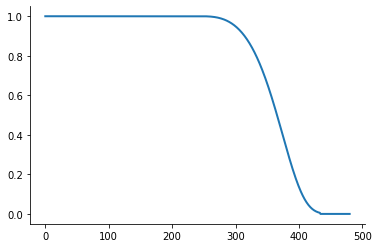

In [811]:
plt.plot(simul_full_1[3])

In [293]:
ems_test = simul_full_1[-1]
dt=1/4

Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(simul_full_1[0])
plt.plot(Time, simul_full_1[0], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
simul_full_1[-3][:,-1].sum()
# plt.plot(simul_full_1[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, Time.max())
plt.legend(loc=2)
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

NameError: name 'simul_full_1' is not defined

(1.1, 3.0)

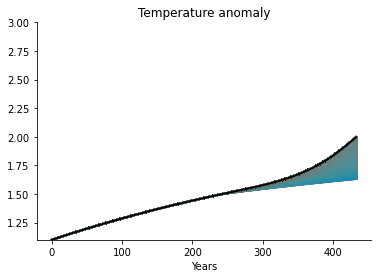

In [813]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(simul_full_1[-5][i, :len(simul_full_1[0])], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(simul_full_1[1], color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

(0.0, 1.0497240728545283)

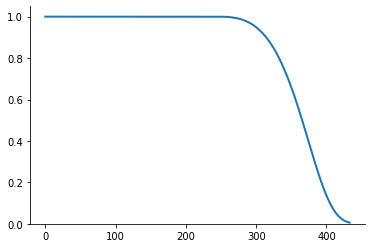

In [814]:
plt.plot(simul_full_1[3][:len(yt)])
plt.ylim(0)

In [815]:
simul_full_1[3], simul_full_1[-2][1], simul_full_1[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = simul_full_1[-4][:,-1]

prob_test.sum()

0.9944814570905659

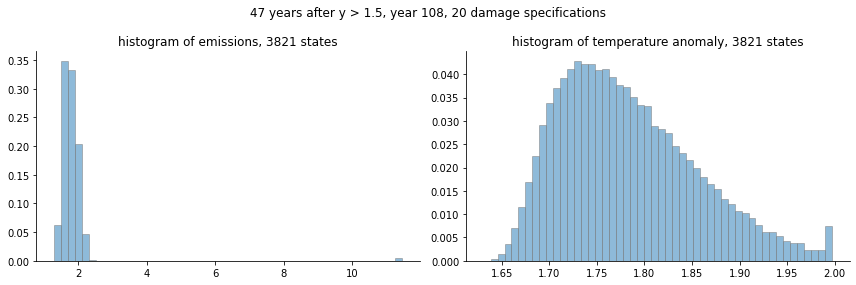

In [816]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
# Periods = int(60*4)
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-5][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)*dt) ,int(t*dt), len(dmg_weight)))
(n, bins, patches) = axes[0].hist(ems_110, weights=prob_110, 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=50,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

# p = axes[0].patches

# distribution = np.zeros(len(p))
# for i in range(len(p)):
#     distribution[i] = p[i].get_height()

# bins = np.array([patch.get_xy()[0] for patch in p])

axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
plt.savefig("../figures/20_damages_large/hist_ems_y_{}.png".format(ξp), dpi=500)
plt.show()

In [817]:
distribution = np.zeros(len(patches))
for i in range(len(patches)):
    distribution[i] = patches[i].get_height()

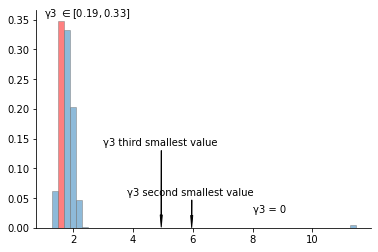

In [818]:
(n, bins, patches) = plt.hist(ems_110, weights=prob_110, 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")

patches[1].set_facecolor('r')

plt.annotate(r"γ3 $\in [0.19, 0.33] $ ",
               xy = (bins[1]+1, distribution[1]),             # top left corner of the histogram bar
               xytext = (0.1,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[18].set_facecolor('r')
plt.annotate(r"γ3 third smallest value ",
               xy = (bins[18], distribution[18]),             # top left corner of the histogram bar
               xytext = (0.1,80),  
                arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )
patches[23].set_facecolor('r')
plt.annotate(r"γ3 second smallest value ",
               xy = (bins[23], distribution[23]),             # top left corner of the histogram bar
               xytext = (0.1,30), 
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[36].set_facecolor('r')
plt.annotate(r"γ3 = 0 ",
               xy = (bins[36], distribution[36]),             # top left corner of the histogram bar
               xytext = (0.1,13),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
             )
# plt.savefig('emission.png', dpi=500)
plt.show()

In [819]:
bins[:],distribution[:]

(array([ 1.28378545,  1.48734231,  1.69089917,  1.89445603,  2.09801289,
         2.30156975,  2.50512661,  2.70868347,  2.91224033,  3.11579719,
         3.31935406,  3.52291092,  3.72646778,  3.93002464,  4.1335815 ,
         4.33713836,  4.54069522,  4.74425208,  4.94780894,  5.1513658 ,
         5.35492267,  5.55847953,  5.76203639,  5.96559325,  6.16915011,
         6.37270697,  6.57626383,  6.77982069,  6.98337755,  7.18693442,
         7.39049128,  7.59404814,  7.797605  ,  8.00116186,  8.20471872,
         8.40827558,  8.61183244,  8.8153893 ,  9.01894616,  9.22250303,
         9.42605989,  9.62961675,  9.83317361, 10.03673047, 10.24028733,
        10.44384419, 10.64740105, 10.85095791, 11.05451477, 11.25807164,
        11.4616285 ]),
 array([0.06175395, 0.34805089, 0.33266295, 0.20339039, 0.04715231,
        0.00147097, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ,

In [820]:
γ3_list[22:]

array([], dtype=float64)

In [821]:
indices = np.where((ems_110 > bins[1]) & (ems_110 < bins[2]))[0]
print(np.unique((indices-1)%40))
for i in range(len(indices)):
    print((indices[i]-1)/40*dt)

for i in range(len(indices)):
    print(int((indices[i]-1)/40)*dt)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39]
0.0125
0.01875
0.025
0.03125
0.0375
0.04375
0.05
0.1375
0.14375
0.15
0.15625
0.1625
0.16875
0.175
0.2625
0.26875
0.275
0.28125
0.2875
0.29375
0.3
0.39375
0.4
0.40625
0.4125
0.41875
0.425
0.51875
0.525
0.53125
0.5375
0.54375
0.55
0.64375
0.65
0.65625
0.6625
0.66875
0.675
0.68125
0.76875
0.775
0.78125
0.7875
0.79375
0.8
0.80625
0.89375
0.9
0.90625
0.9125
0.91875
0.925
0.93125
1.01875
1.025
1.03125
1.0375
1.04375
1.05
1.05625
1.14375
1.15
1.15625
1.1625
1.16875
1.175
1.18125
1.26875
1.275
1.28125
1.2875
1.29375
1.3
1.30625
1.39375
1.4
1.40625
1.4125
1.41875
1.425
1.43125
1.51875
1.525
1.53125
1.5375
1.54375
1.55
1.55625
1.64375
1.65
1.65625
1.6625
1.66875
1.675
1.68125
1.76875
1.775
1.78125
1.7875
1.79375
1.8
1.80625
1.89375
1.9
1.90625
1.9125
1.91875
1.925
1.93125
2.01875
2.025
2.03125
2.0375
2.04375
2.05
2.05625
2.14375
2.15
2.15625
2.1625
2.16875
2.175
2.18125
2.26875
2.275
2.

[]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

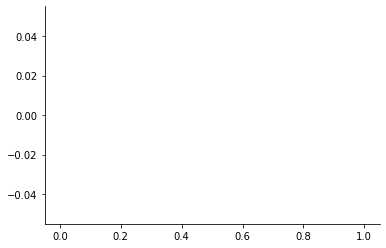

In [822]:
indices = np.where((ems_110 >= bins[18]) & (ems_110 <= bins[19]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

In [823]:
indices = np.where((ems_110 >= bins[23]) & (ems_110 <= bins[24]))[0]
print(np.unique((indices-1)%40))
print(np.array((indices-1)/40, dtype=int)*dt)

[]
[]


[]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

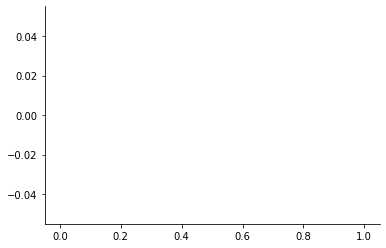

In [824]:
indices = np.where((ems_110 >= bins[36]) & (ems_110 <= bins[37]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

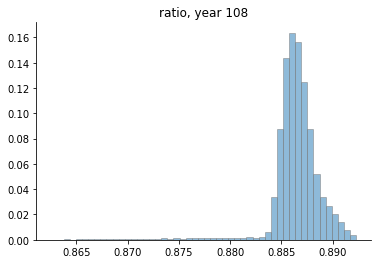

In [825]:
plt.hist(simul_full_1[5][1:,len(simul_full_1[0])], weights=simul_full_1[-4][1:,len(simul_full_1[0])],
         bins=50,
         alpha=0.5, ec="gray",)
plt.title("ratio, year {:d}".format(int(t*dt)))
plt.savefig("../figures/20_damages_large/ratio_{}.png".format(ξp), dpi=500)

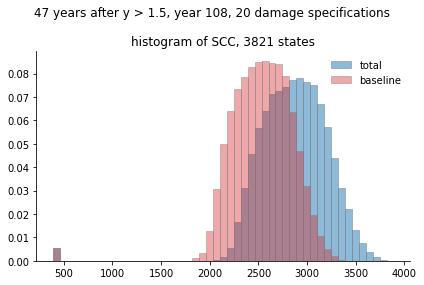

In [826]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]

me_110 = simul_full_1[4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

scc = η/ems_110/MCt[t]*1000
scc0 = me_110/MCt[t]*1000

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(scc, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
             alpha=0.5, ec="gray", label="total")
axes.hist(scc0, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
              color="tab:red",
             alpha=0.4, ec="gray", label="baseline")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
axes.legend()
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
plt.savefig("../figures/20_damages_large/hist_scc_{}.png".format(ξp), dpi=500)
# plt.show()

NameError: name 'p' is not defined

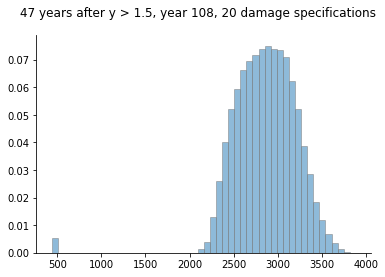

In [827]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int(t*dt-Periods*dt + (len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(η/ems_110/MCt[t]*1000, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("hist_scc_116.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-55, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [ ]:
prob_110.sum()

In [ ]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]

plt.hist(ems_test[:, t], weights=prob_110, bins=np.linspace(0,12,20))
plt.hist(ems_110, weights=prob_110, bins=20)

In [ ]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])
ems_110 = simul_full_1[-1][:, t]
ems_test[:, t].max(), ems_110.max(), Periods, ems_test[41]

In [ ]:
plt.plot(ems_test[81, :447])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    ax1.plot(Time, η/ems_test[i, :Periods]/MCt[:Periods]*1000, 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)


ax1.plot(Time, η/simul_full_1[0]/MCt[:Periods]*1000, color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_1[0])*dt)
ax1.legend()

# plot2


ax2.hist(η/ems_110/MCt[t]*1000, weights=prob_110, 
#          bins=np.linspace(0,12,20),
         bins=50,
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])


# ax2.set_xlim(1,14)
# ax2.set_ylim(0,12)
# ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year {}".format(len(ems_110), t*dt))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
# plt.savefig("../figures/20_damages/emission_hist_new.png",facecolor="w", edgecolor="w", dpi=500)

In [ ]:
prob_110[0]

In [ ]:
len(simul_full_2[0])/4

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_2[-1]
Periods = len(simul_full_2[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no2[0])-1
ems_110 = simul_full_2[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_2[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_2[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(simul_full_2[0])
ax1.plot(Time, simul_no2[0], color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_2[0])*dt)
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, 
         bins=np.linspace(0,12,20),
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

# ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
# ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
#         ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,12)
ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 91".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_2.png",facecolor="w", edgecolor="w", dpi=1000)

In [ ]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [ ]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')